# Project 4

In [676]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
import numpy as np

## Part 1

### Cleaning the data

In [ ]:
df = pd.read_csv('cleveland.csv')
df.rename(columns={'num': 'disease'}, inplace=True)
df['disease'] = df.disease.apply(lambda x: min(x, 1))
df.loc[df['ca'] == '?', 'ca'] = None
df.loc[df['thal'] == '?', 'thal'] = None
df['ca'] = df['ca'].apply(lambda a: float(a) if (a is not None) else None)
df['thal'] = df['thal'].apply(lambda a: float(a) if (a is not None) else None)
display(df)
df.dropna().corr()

### Testing predictions using KNN

In [ ]:
def testDataset(dataframe, testCol, k=5, attributes=1, verbose=True):
    df = dataframe.copy()

    # Test a random set of attributes
    if type(attributes) == int:
        # If more attributes are specified than there are, just use all of them
        if attributes > len(df.columns)-1:
            attributes = len(df.columns)-1
        attributes = df[df.columns[df.columns != testCol]].sample(axis=1, n=attributes).columns

    # Test a specific set of attributes
    elif type(attributes) != list:
        print('attributes must be an integer or a list of attribute names')
        return


    # Clear out any records that don't have a valid value for one of the attributes in question
    for attribute in attributes:
        if attribute == testCol:
            print(f'Cannot predict {testCol} using {testCol}')
            return
        
        try:
            df = df.dropna(subset=attribute)
        except Exception as e:
            print(e)
            return
    
    print(f'Predicting based on the {k} nearest neighbors using {attributes}:') if verbose else None
    # display(df)

    # Standardize the data
    for attribute in attributes:
        df[attribute] = (df[attribute] - df[attribute].mean()) / df[attribute].std()

    f1Scores = []
    for j in range(10):
        # Use knn. First create a nearest neighbors object.
        nn = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='auto')
        
        X = df[attributes].values
        y = df[[testCol]].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)#, random_state=42)

        fit = nn.fit(X_train)

        distances, indices = fit.kneighbors(X_test)
        
        y_pred = []
        for i in range(len(indices)):
            nbrs = y_train[indices[i]]
            

            # Predict the class with the highest frequency among neighbors
            greatestValue = df[testCol].unique()[0]

            greatestValueCount = 0
            for value in df[testCol].unique():
                valueCount = [item for sublist in nbrs for item in sublist].count(value)

                if valueCount >= greatestValueCount:
                    greatestValueCount = valueCount
                    greatestValue = value

            # healthy = [item for sublist in nbrs for item in sublist].count(0)
            # sick = [item for sublist in nbrs for item in sublist].count(1)
            predict = greatestValue
            # print(healthy, sick, predict)

            y_pred.append(predict)
        
        (p,r,f,s) = precision_recall_fscore_support(y_test, y_pred, zero_division = 0)
        f1Scores.append(f)
        print(f'Test {j}: precision={p}, recall={r}, f-score={f}, support={s}') if verbose else None

    meanF1s = []
    for i in range(len(f1Scores[0])):
        f1Total = 0
        for score in f1Scores:
            f1Total += score[i]
        meanF1s.append(f1Total / len(f1Scores))

    print(f'Mean F1 scores: f-score={meanF1s}') if verbose else None

    f1sTotal = 0
    for f1 in meanF1s:
        f1sTotal += f1
    meanOfF1s = f1sTotal / len(meanF1s)
    meanF1s.append(meanOfF1s)

    print(f'Mean of mean F1 scores: f-score={meanF1s[-1]}') if verbose else None

    return meanF1s, attributes

#### Running random tests to find some promising combinations

In [702]:
# testDataset(df, 'disease', 5, ['oldpeak', 'cp'])
# testDataset(df, 'disease', 5, ['thalach', 'ca', 'thal'])
# testDataset(df, 'disease', 5, ['oldpeak', 'age', 'cp'])
# testDataset(df, 'disease', 5, ['slope', 'thal', 'cp'])
testDataset(df, 'disease', 5, 3)

Predicting based on the 5 nearest neighbors using Index(['cp', 'trestbps', 'oldpeak'], dtype='object'):
Test 0: precision=[0.77272727 0.875     ], recall=[0.89473684 0.73684211], f-score=[0.82926829 0.8       ], support=[38 38]
Test 1: precision=[0.72916667 0.89285714], recall=[0.92105263 0.65789474], f-score=[0.81395349 0.75757576], support=[38 38]
Test 2: precision=[0.7173913  0.83333333], recall=[0.86842105 0.65789474], f-score=[0.78571429 0.73529412], support=[38 38]
Test 3: precision=[0.77083333 0.64285714], recall=[0.78723404 0.62068966], f-score=[0.77894737 0.63157895], support=[47 29]
Test 4: precision=[0.79487179 0.72972973], recall=[0.75609756 0.77142857], f-score=[0.775 0.75 ], support=[41 35]
Test 5: precision=[0.79069767 0.75757576], recall=[0.80952381 0.73529412], f-score=[0.8        0.74626866], support=[42 34]
Test 6: precision=[0.77777778 0.70967742], recall=[0.79545455 0.6875    ], f-score=[0.78651685 0.6984127 ], support=[44 32]
Test 7: precision=[0.77272727 0.6875  

([0.7906309756467192, 0.7216434099288982, 0.7561371927878087],
 Index(['cp', 'trestbps', 'oldpeak'], dtype='object'))

#### Testing different k values on a promising combination

Text(0, 0.5, 'f score')

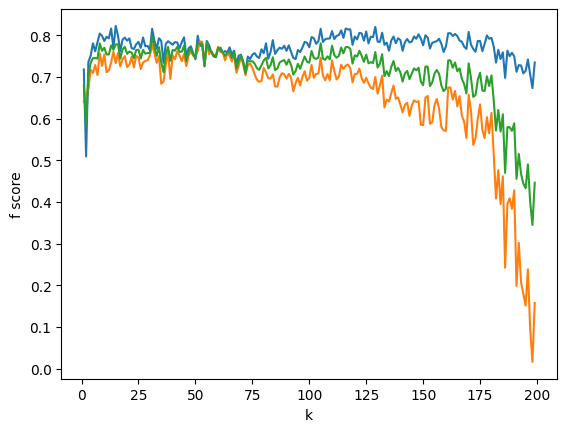

In [704]:
scores = {'k': [], 'scores': []}
for k in range(1, 200):
    scores['k'].append(k)
    fScores, attributes = testDataset(dataframe=df, testCol='disease', k=k, attributes=['oldpeak', 'cp'], verbose=False)
    scores['scores'].append(fScores)

plt.plot(scores['k'], scores['scores'])
plt.xlabel('k')
plt.ylabel('f score')

#### Testing combinations of k values and numbers of attributes

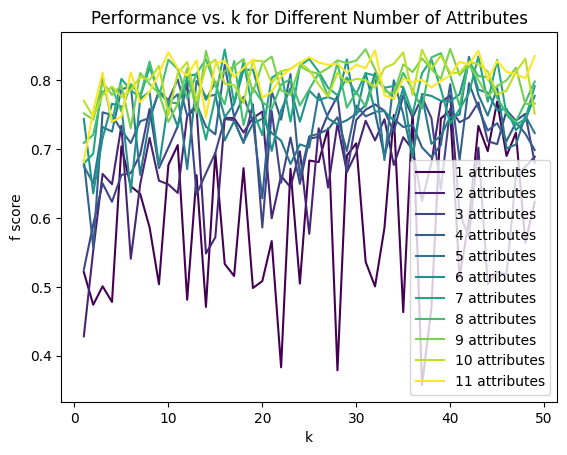

[45, 40, 12, 16, 42, 29, 16, 39, 40, 37, 32]

[0.7693690142747436,
 0.7782408257867262,
 0.796888769681205,
 0.8229511846488158,
 0.8342823124829978,
 0.8307057169333183,
 0.8450164531194455,
 0.8396638684407588,
 0.8458653310903002,
 0.8445261945243137,
 0.8436568628074684]

[Index(['age'], dtype='object'),
 Index(['trestbps', 'thalach'], dtype='object'),
 Index(['restecg', 'age', 'thalach'], dtype='object'),
 Index(['ca', 'restecg', 'fbs', 'age'], dtype='object'),
 Index(['cp', 'trestbps', 'ca', 'age', 'fbs'], dtype='object'),
 Index(['fbs', 'exang', 'cp', 'sex', 'slope', 'thalach'], dtype='object'),
 Index(['sex', 'exang', 'ca', 'cp', 'age', 'trestbps', 'slope'], dtype='object'),
 Index(['chol', 'age', 'sex', 'thal', 'exang', 'cp', 'slope', 'fbs'], dtype='object'),
 Index(['thalach', 'sex', 'cp', 'slope', 'ca', 'fbs', 'chol', 'restecg', 'age'], dtype='object'),
 Index(['trestbps', 'ca', 'exang', 'thalach', 'oldpeak', 'age', 'fbs',
        'restecg', 'chol', 'sex'],
       dtype='object'),
 Index(['restecg', 'exang', 'cp', 'fbs', 'thal', 'thalach', 'slope', 'ca',
        'sex', 'chol', 'trestbps'],
       dtype='object')]

In [670]:
num_attributes = 11

# Create a color map
colors = viridis(np.linspace(0, 1, num_attributes))
highestKs = []
highestFScores = []
bestAttributes = []
# Plot each curve with a different color based on the number of attributes
for j in range(1, num_attributes + 1):
    scores = {'k': [], 'scores': [], 'attributes': []}
    highestFScore = 0
    highestK = 0
    bestAttribute = []
    for k in range(1, 50):
        scores['k'].append(k)
        new_scores, randomAttributes = testDataset(dataframe=df, testCol='disease', k=k, attributes=j, verbose=False)
        scores['scores'].append(new_scores[2])

        if highestFScore < new_scores[2]:
            highestFScore = new_scores[2]
            highestK = k
            bestAttribute = randomAttributes

    # Use a different color for each curve
    plt.plot(scores['k'], scores['scores'], label=f"{j} attributes", color=colors[j-1])
    highestKs.append(highestK)
    highestFScores.append(highestFScore)
    bestAttributes.append(randomAttributes)
    



plt.xlabel('k')
plt.ylabel('f score')
plt.title('Performance vs. k for Different Number of Attributes')
plt.legend()
plt.show()


display(highestKs)
display(highestFScores)
display(bestAttributes)







In [671]:

max_value = max(highestFScores)
index_of_max = highestFScores.index(max_value)


display(testDataset(df, 'disease', highestKs[index_of_max], list(bestAttributes[index_of_max])))

Predicting based on the 40 nearest neighbors using ['thalach', 'sex', 'cp', 'slope', 'ca', 'fbs', 'chol', 'restecg', 'age']:
Test 0: precision=[0.82608696 0.79310345], recall=[0.86363636 0.74193548], f-score=[0.84444444 0.76666667], support=[44 31]
Test 1: precision=[0.79069767 0.875     ], recall=[0.89473684 0.75675676], f-score=[0.83950617 0.8115942 ], support=[38 37]
Test 2: precision=[0.81395349 0.75      ], recall=[0.81395349 0.75      ], f-score=[0.81395349 0.75      ], support=[43 32]
Test 3: precision=[0.7  0.76], recall=[0.85365854 0.55882353], f-score=[0.76923077 0.6440678 ], support=[41 34]
Test 4: precision=[0.81632653 0.88461538], recall=[0.93023256 0.71875   ], f-score=[0.86956522 0.79310345], support=[43 32]
Test 5: precision=[0.69565217 0.79310345], recall=[0.84210526 0.62162162], f-score=[0.76190476 0.6969697 ], support=[38 37]
Test 6: precision=[0.77272727 0.90322581], recall=[0.91891892 0.73684211], f-score=[0.83950617 0.8115942 ], support=[37 38]
Test 7: precision=[

([0.8072696273000035, 0.7415224484266039, 0.7743960378633037],
 ['thalach', 'sex', 'cp', 'slope', 'ca', 'fbs', 'chol', 'restecg', 'age'])

#### Arriving on a winning combination

Given the results of the test we ran, we are 'usually' around 10 or 11 attributes, so hand select that many. It is also between 20 and 35 K values 'usually', so use that many.

In [672]:
attributesToTest = ['age', 'sex','cp','trestbps','chol','fbs','restecg','ca','oldpeak','exang','thal']
display(testDataset(df, 'disease', 25, attributesToTest))

Predicting based on the 25 nearest neighbors using ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'ca', 'oldpeak', 'exang', 'thal']:
Test 0: precision=[0.85714286 0.84615385], recall=[0.91304348 0.75862069], f-score=[0.88421053 0.8       ], support=[46 29]
Test 1: precision=[0.75       0.81481481], recall=[0.87804878 0.64705882], f-score=[0.80898876 0.72131148], support=[41 34]
Test 2: precision=[0.92682927 0.85294118], recall=[0.88372093 0.90625   ], f-score=[0.9047619  0.87878788], support=[43 32]
Test 3: precision=[0.76 0.76], recall=[0.86363636 0.61290323], f-score=[0.80851064 0.67857143], support=[44 31]
Test 4: precision=[0.85714286 0.84848485], recall=[0.87804878 0.82352941], f-score=[0.86746988 0.8358209 ], support=[41 34]
Test 5: precision=[0.8372093 0.90625  ], recall=[0.92307692 0.80555556], f-score=[0.87804878 0.85294118], support=[39 36]
Test 6: precision=[0.79166667 0.77777778], recall=[0.86363636 0.67741935], f-score=[0.82608696 0.72413793], support=[44 31]
T

([0.848800968795054, 0.7935433620963785, 0.8211721654457163],
 ['age',
  'sex',
  'cp',
  'trestbps',
  'chol',
  'fbs',
  'restecg',
  'ca',
  'oldpeak',
  'exang',
  'thal'])

### Challenge

In [698]:
def challenge(testDataFrame, trainDataFrame, testCol, k=5, attributes=1, verbose=True):
    testDF = testDataFrame.copy()
    trainDF = trainDataFrame.copy()

    # Test a random set of attributes
    if type(attributes) == int:
        # If more attributes are specified than there are, just use all of them
        if attributes > len(testDF.columns)-1:
            attributes = len(testDF.columns)-1
        attributes = testDF[testDF.columns[testDF.columns != testCol]].sample(axis=1, n=attributes).columns

    # Test a specific set of attributes
    elif type(attributes) != list:
        print('attributes must be an integer or a list of attribute names')
        return


    # Clear out any records that don't have a valid value for one of the attributes in question
    for attribute in attributes:
        if attribute == testCol:
            print(f'Cannot predict {testCol} using {testCol}')
            return
        
        try:
            testDF = testDF.dropna(subset=attribute)
            trainDF = trainDF.dropna(subset=attribute)
        except Exception as e:
            print(e)
            return
    
    print(f'Predicting based on the {k} nearest neighbors using {attributes}:') if verbose else None
    # display(testDF)

    # Standardize the data
    for attribute in attributes:
        testDF[attribute] = (testDF[attribute] - testDF[attribute].mean()) / testDF[attribute].std()
        trainDF[attribute] = (trainDF[attribute] - trainDF[attribute].mean()) / trainDF[attribute].std()
    
    # Use knn. First create a nearest neighbors object.
    nn = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='auto')
    
    X_train = trainDF[attributes].values
    X_test = testDF[attributes].values
    y_train = trainDF[[testCol]].values
    y_test = testDF[[testCol]].values

    fit = nn.fit(X_train)

    distances, indices = fit.kneighbors(X_test)
    
    y_pred = []
    for i in range(len(indices)):
        nbrs = y_train[indices[i]]
        

        # Predict the class with the highest frequency among neighbors
        greatestValue = trainDF[testCol].unique()[0]

        greatestValueCount = 0
        for value in trainDF[testCol].unique():
            valueCount = [item for sublist in nbrs for item in sublist].count(value)

            if valueCount >= greatestValueCount:
                greatestValueCount = valueCount
                greatestValue = value

        # healthy = [item for sublist in nbrs for item in sublist].count(0)
        # sick = [item for sublist in nbrs for item in sublist].count(1)
        predict = greatestValue
        # print(healthy, sick, predict)

        y_pred.append(predict)
        
    (p,r,f,s) = precision_recall_fscore_support(y_test, y_pred, zero_division = 0)
    print(f'precision={p}, recall={r}, f-score={f}, support={s}') if verbose else None

    f1Total = 0
    for f1 in f:
        f1Total += f1
    meanF1 = f1Total / len(f)

    print(f'Mean of F1 scores: f-score={meanF1}') if verbose else None
    
    f1Scores = f.tolist()
    f1Scores.append(meanF1)

    return f1Scores, attributes

#### Cleaning the challenge test dataset

In [683]:
challengeDataset = 'cleveland-test-sample.csv'
challengeDF = pd.read_csv(challengeDataset)
challengeDF.rename(columns={'num': 'disease'}, inplace=True)
challengeDF['disease'] = challengeDF.disease.apply(lambda x: min(x, 1))
challengeDF.loc[challengeDF['ca'] == '?', 'ca'] = None
challengeDF.loc[challengeDF['thal'] == '?', 'thal'] = None
challengeDF['ca'] = challengeDF['ca'].apply(lambda a: float(a) if (a is not None) else None)
challengeDF['thal'] = challengeDF['thal'].apply(lambda a: float(a) if (a is not None) else None)
display(challengeDF)

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,263,44.0,1.0,3.0,120.0,226.0,0.0,0.0,169.0,0.0,0.0,1.0,0.0,3.0,0
1,114,62.0,0.0,3.0,130.0,263.0,0.0,0.0,97.0,0.0,1.2,2.0,1.0,7.0,1
2,75,65.0,0.0,3.0,160.0,360.0,0.0,2.0,151.0,0.0,0.8,1.0,0.0,3.0,0
3,147,41.0,1.0,3.0,112.0,250.0,0.0,0.0,179.0,0.0,0.0,1.0,0.0,3.0,0
4,210,37.0,0.0,3.0,120.0,215.0,0.0,0.0,170.0,0.0,0.0,1.0,0.0,3.0,0
5,233,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,0
6,298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
7,118,63.0,1.0,4.0,130.0,330.0,1.0,2.0,132.0,1.0,1.8,1.0,3.0,7.0,1
8,254,43.0,1.0,4.0,115.0,303.0,0.0,0.0,181.0,0.0,1.2,2.0,0.0,3.0,0
9,48,65.0,0.0,3.0,140.0,417.0,1.0,2.0,157.0,0.0,0.8,1.0,1.0,3.0,0


#### Running a prediction on the challenge dataset using the optimal attributes and k value for a KNN model

In [699]:
attributesToTest = ['age', 'sex','cp','trestbps','chol','fbs','restecg','ca','oldpeak','exang','thal']
k = 25
display(challenge(testDataFrame=challengeDF, trainDataFrame=df, testCol='disease', k=k, attributes=attributesToTest, verbose=True))

Predicting based on the 25 nearest neighbors using ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'ca', 'oldpeak', 'exang', 'thal']:
precision=[0.82608696 0.875     ], recall=[0.9047619  0.77777778], f-score=[0.86363636 0.82352941], support=[21 18]
Mean of F1 scores: f-score=0.8435828877005347


([0.8636363636363636, 0.8235294117647058, 0.8435828877005347],
 ['age',
  'sex',
  'cp',
  'trestbps',
  'chol',
  'fbs',
  'restecg',
  'ca',
  'oldpeak',
  'exang',
  'thal'])

## Part 2